In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
import peaks_utility as psu
import s2_selection_utility as ssu
from multihist import Hist1d, Histdd
import time
import itertools
import os
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

Start import
Working on midway2-0425.rcc.local with the following versions 
and installation paths:
strax
	v0.12.4	/dali/lgrandi/strax/strax/strax
straxen
	v0.12.3	/dali/lgrandi/strax/straxen/straxen



In [3]:
st = straxen.contexts.xenonnt_online()

In [4]:
PMTs = [93, 188, 206]
run_id = '009746'
events = st.get_array(run_id,'event_basics')
peaks = st.get_array(run_id,'peak_basics')
run_id2 = '009748'
events2 = st.get_array(run_id2,'event_basics')
peaks2 = st.get_array(run_id2,'peak_basics')
ndiv = 10
start = [0, 4574, 9069, 13611, 18127, 22632, 27178, 31688, 36148, 40709, 45191]
start2 = [0,0,0,0,0,0,0,0,0,0,0]

run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 0, tot. events 197904, selected 4574, tot.sel. 4574 time to process 8.55 s


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 1, tot. events 198461, selected 4495, tot.sel. 9069 time to process 7.32 s


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 2, tot. events 199761, selected 4542, tot.sel. 13611 time to process 7.91 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 3, tot. events 200159, selected 4516, tot.sel. 18127 time to process 8.61 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 4, tot. events 199798, selected 4505, tot.sel. 22632 time to process 7.32 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 5, tot. events 197944, selected 4546, tot.sel. 27178 time to process 7.75 s


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 6, tot. events 199575, selected 4510, tot.sel. 31688 time to process 8.33 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 7, tot. events 196980, selected 4460, tot.sel. 36148 time to process 7.78 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 8, tot. events 196917, selected 4561, tot.sel. 40709 time to process 6.80 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 9, tot. events 198587, selected 4482, tot.sel. 45191 time to process 7.17 s


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


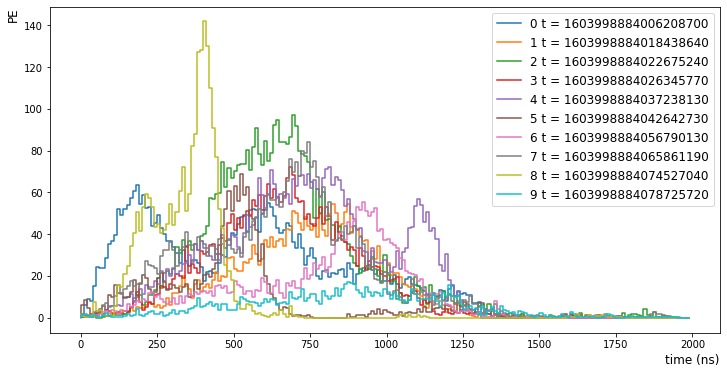

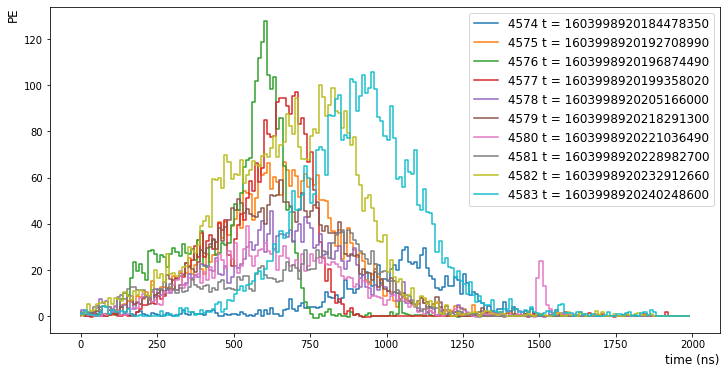

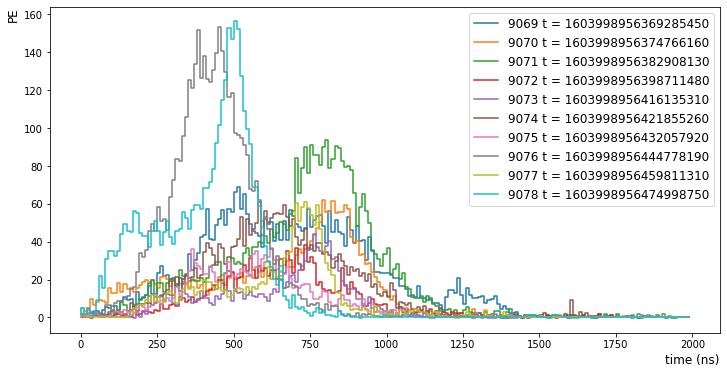

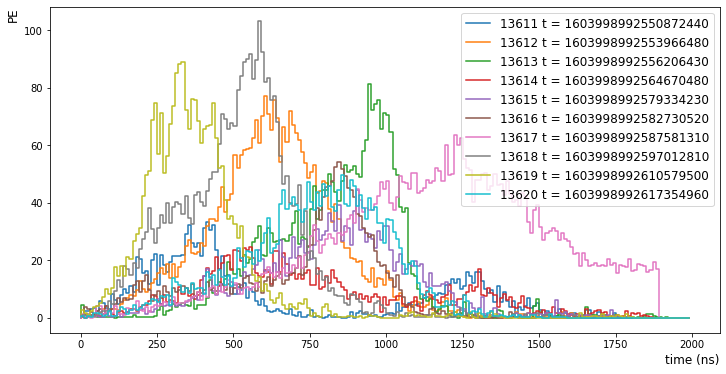

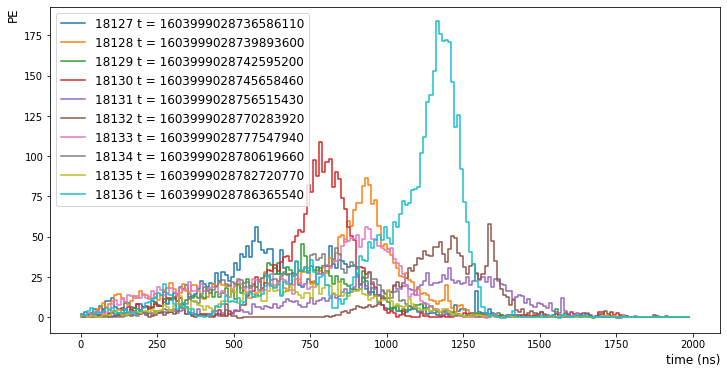

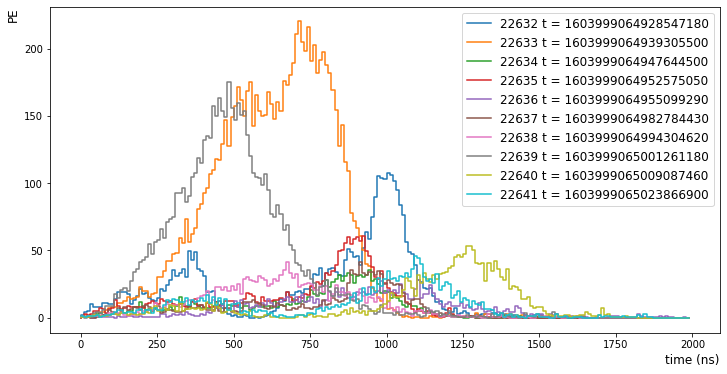

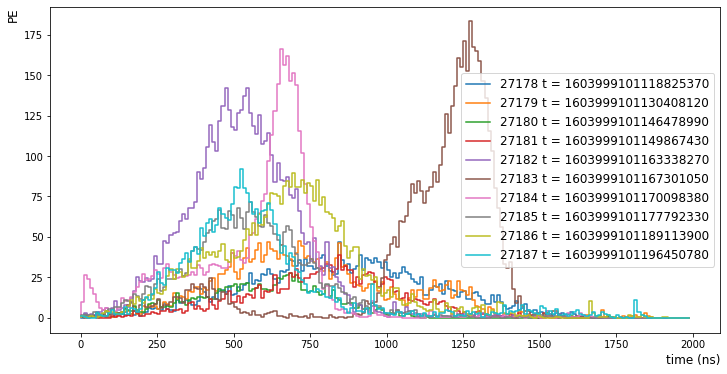

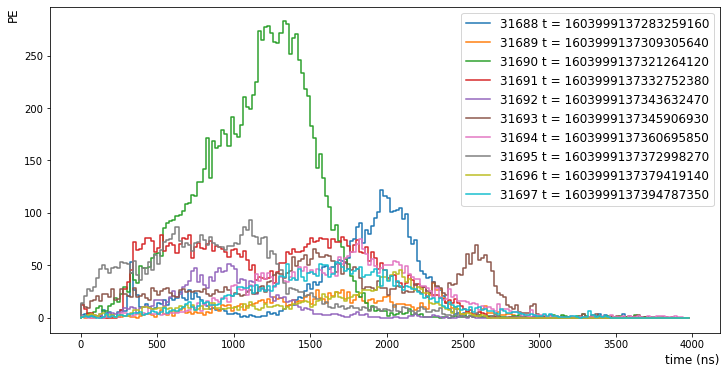

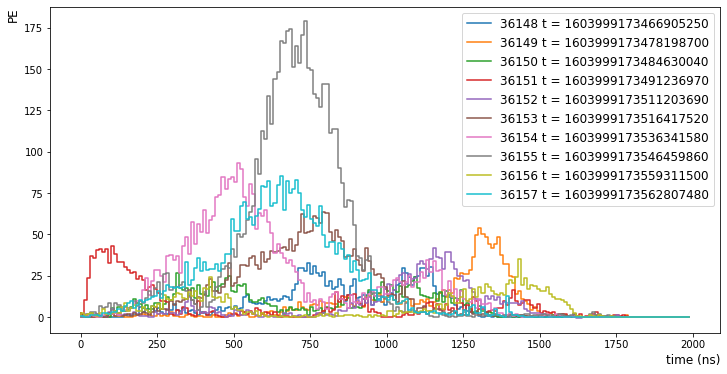

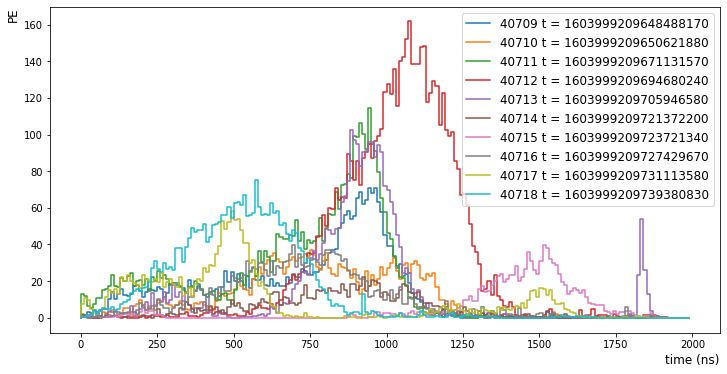

In [6]:
for div in range(ndiv):
    pdata, start[div+1] = ssu.select_peaks_times(st, run_id, peaks, events, ndiv, div, int(start[div]))

In [4]:
for div in range(ndiv):
    filename = f'data/select_peaks_run{run_id}_div{div}.h5'
    pdata = pd.read_hdf(filename)
    rdata = ssu.select_records_times(st,run_id,peaks,events,pdata,PMTs,ndiv,div,int(start[div]))

run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 0, tot. events 7549851, selected events: 66090 4574, time to process: 24.12 s


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['data'], dtype='object')]

  encoding=encoding,


run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 1, tot. events 7517854, selected events: 65143 9069, time to process: 24.17 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 2, tot. events 7608556, selected events: 66782 13611, time to process: 24.56 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 3, tot. events 7587655, selected events: 64547 18127, time to process: 25.02 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 4, tot. events 7567999, selected events: 66407 22632, time to process: 23.57 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 5, tot. events 7499897, selected events: 65954 27178, time to process: 24.10 s
run 009746 Total events 45192 total peaks 1986087 duration 361.83023416
division n. 6, tot. events 7531967, selected events: 65786 31688, time to process: 26.62 s
run 009746 Total events

In [5]:
mdata = ssu.merge_records(run_id, PMTs, ndiv = 10)

Reading: ./data/select_records_run009746_div0.h5, initial records: 66090, events: 4573
0, time to process: 0.93


/home/valerioda/xenon-notes/fast_response_analysis/s2_selection_utility.py:288: RuntimeWarning: invalid value encountered in double_scalars
  rec_x /= area_sum
/home/valerioda/xenon-notes/fast_response_analysis/s2_selection_utility.py:289: RuntimeWarning: invalid value encountered in double_scalars
  rec_y /= area_sum


1000, time to process: 21.52
2000, time to process: 42.45
3000, time to process: 63.54
4000, time to process: 84.97
Merged records 13685
Reading: ./data/select_records_run009746_div1.h5, initial records: 65143, events: 4494
4574, time to process: 97.92
5000, time to process: 106.96
6000, time to process: 129.29
7000, time to process: 151.13
8000, time to process: 172.69
9000, time to process: 194.30
Merged records 27135
Reading: ./data/select_records_run009746_div2.h5, initial records: 66782, events: 4541
9069, time to process: 196.85
10000, time to process: 217.22
11000, time to process: 239.37
12000, time to process: 260.99
13000, time to process: 282.49
Merged records 40734
Reading: ./data/select_records_run009746_div3.h5, initial records: 64547, events: 4515
13611, time to process: 296.72
14000, time to process: 305.39
15000, time to process: 326.78
16000, time to process: 348.69
17000, time to process: 370.30
18000, time to process: 391.66
Merged records 54242
Reading: ./data/sele

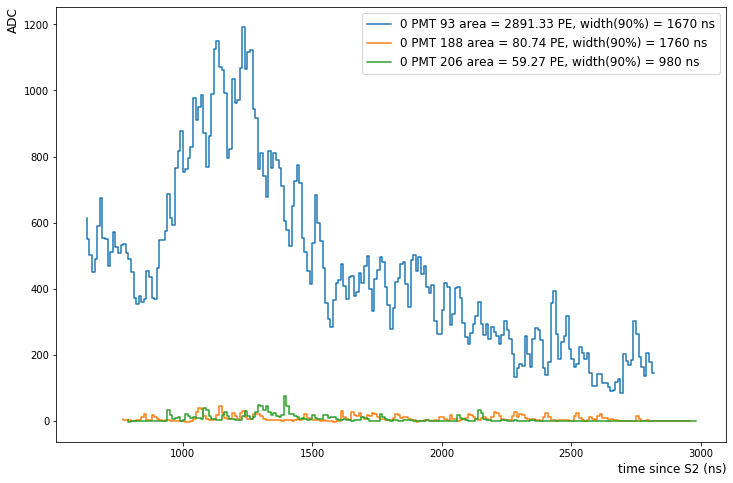

In [4]:
ssu.plot_records(run_id,PMTs,n=1)

In [ ]:
plot_positions_area(run_id,PMTs)

PMT 93 events 45135
PMT 188 events 45094
PMT 206 events 45028


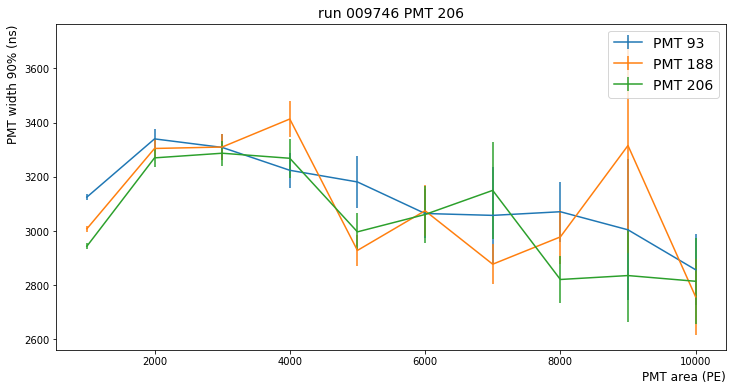

In [11]:
m, s = ssu.width_distribution_slice(run_id, PMTs)

PMT 93 events 45179
PMT 188 events 45167
PMT 206 events 45144


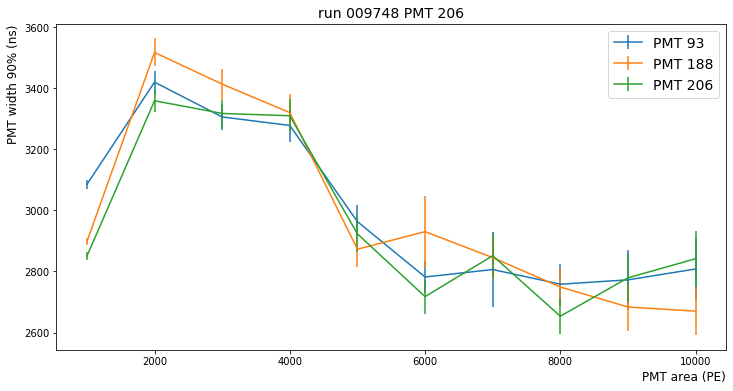

In [10]:
m, s = ssu.width_distribution_slice(run_id2, PMTs)

PMT n. 93 events 45135
PMT n. 188 events 45094
PMT n. 206 events 45028


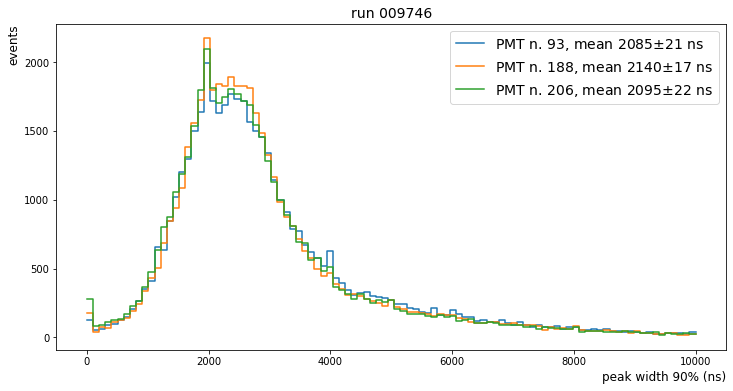

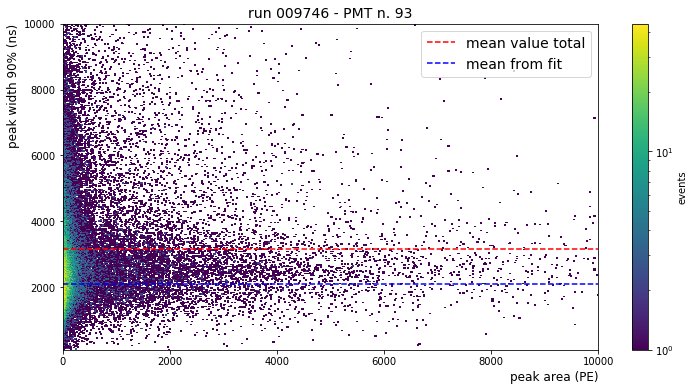

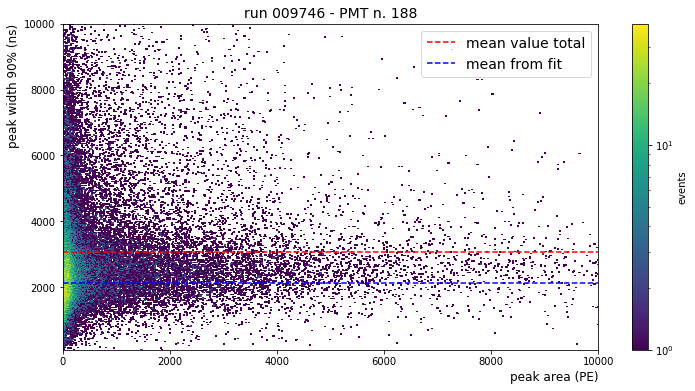

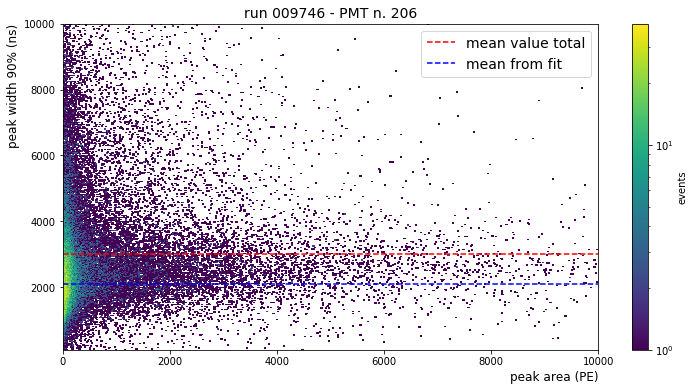

In [13]:
ssu.plot_area_width90_position(run_id, PMTs, 1e4, 1e4)

PMT n. 93 events 9240
PMT n. 188 events 10275
PMT n. 206 events 9760


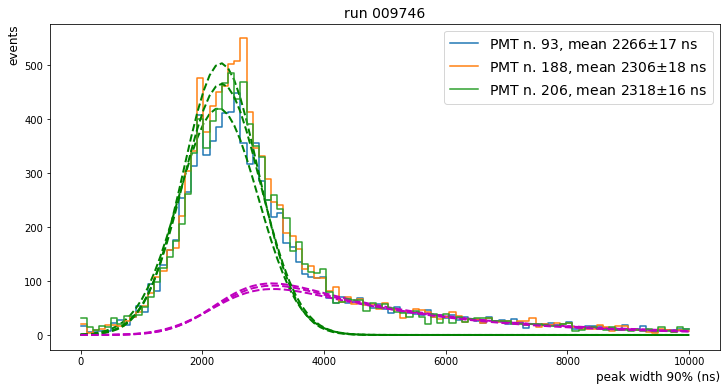

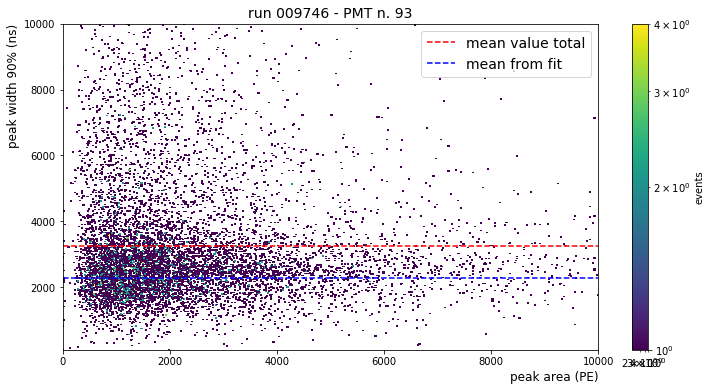

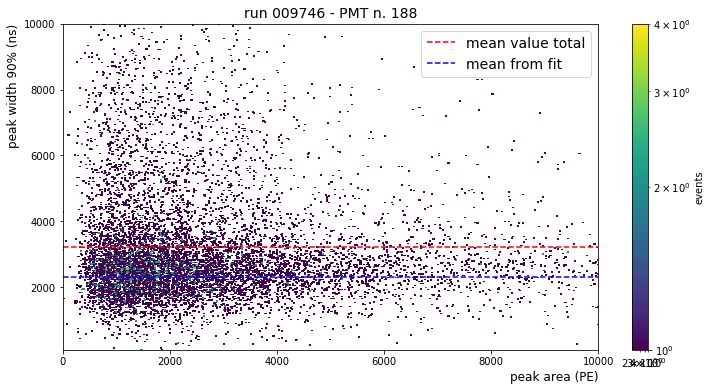

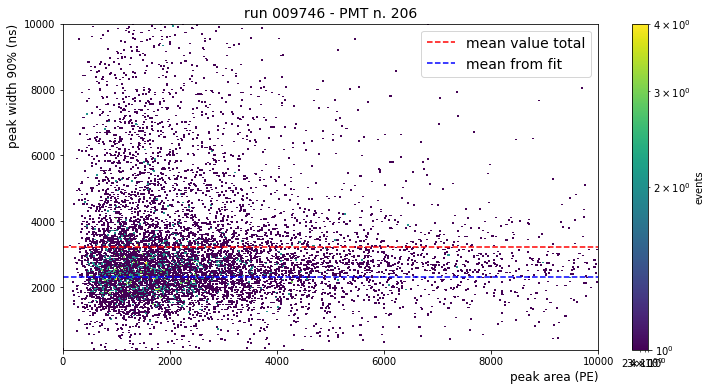

In [14]:
ssu.plot_area_width90_position(run_id, PMTs, 1e4, 1e4, position = 1, distance=8,plot=1)

In [27]:
from scipy.optimize import curve_fit
def plot_area_width90_position(run_id, PMTs, area_lim=1e4, width_lim=1e4,position=False,distance=8, plot=False):
    mdata = pd.read_hdf(f'data/merged_records_run{run_id}.h5')
    mdata = mdata[(mdata['area']>500)&(mdata['drift_time']>0)&((mdata['s2_time']-mdata['s1_endtime'])>200)]
    
    positions = straxen.pmt_positions()

    for i, PMT in enumerate(PMTs):
        pos_x = np.float(positions['x'][positions['i']==PMT])
        pos_y = np.float(positions['y'][positions['i']==PMT])
        mdata1 = mdata[(mdata['channel']==PMT)]
        if position:
            mdata1 = mdata1[(mdata1['position_x']<pos_x+distance) & (mdata1['position_x']>pos_x-distance) &
                            (mdata1['position_y']<pos_y+distance) & (mdata1['position_y']>pos_y-distance)]
        print('PMT n.',PMT,'events',len(mdata1))
        
        # width 50%
        plt.figure(0,figsize=(12,6))
        bins50 = np.linspace(0, width_lim, int(width_lim/20))
        ph50 = Hist1d(mdata1['width50'],bins=bins50)
        pha50 = np.array(ph50)
        popt50, pcov50 = curve_fit(ssu.gauss_tail, bins50[12:len(ph50)],
                                   pha50[12:], p0 = np.array([150, 1000, 1000,0.5,100]))
        perr50 = np.sqrt(np.diag(pcov50))
        mu50, mu50_err = popt50[1], perr50[1]
        ph50.plot(label=f'PMT n. {PMT}, mean {mu50:.0f}$\pm${mu50_err:.0f} ns')
        #me50, me50_err = mdata1['width50'].mean(), mdata1['width50'].std()/np.sqrt(len(mdata1))
        #ph50.plot(label=f'PMT n. {PMT}, mean {me50:.0f}$\pm${me50_err:.0f} ns')
        if plot:
            h, gaus, tail = ssu.gauss_tail(bins50, *popt50, components=True)
            gaus = np.array(gaus)
            tail = np.array(tail)
            plt.plot(bins50, gaus, ls="--", lw=2, c='g')
            plt.plot(bins50, tail, ls='--', lw=2, c='m')
        plt.ylabel("events", ha='right', y=1,fontsize=12)
        plt.xlabel("peak width 50% (ns)", ha='right', x=1,fontsize=12)
        plt.xlim(0,3000)
        plt.title(f'run {run_id} - width 50%',fontsize=14)
        plt.legend(fontsize=14)
        
        # width 90%
        plt.figure(1,figsize=(12,6))
        bins = np.linspace(0, width_lim, int(width_lim/40))
        ph = Hist1d(mdata1['width90'],bins=bins)
        media_tot = mdata1['width90'].mean()
        pha = np.array(ph)
        popt, pcov = curve_fit(ssu.gauss_tail, bins[:len(ph)], pha, p0 = np.array([200, 2200, 400,0.2,100]))
        perr = np.sqrt(np.diag(pcov))
        mu, mu_err = popt[1], perr[1]
        #ph.plot(label=f'PMT n. {PMT}, mean {media_tot:.0f}$\pm${stand_tot:.0f} {mu:.0f}$\pm${mu_err:.0f} ns')
        ph.plot(label=f'PMT n. {PMT}, mean {mu:.0f}$\pm${mu_err:.0f} ns')
        if plot:
            #plt.plot(bins,gauss_tail(bins, *popt), c='r',label=f'fit {popt[1]} +/- {perr[1]}')
            h, gaus, tail = ssu.gauss_tail(bins, *popt, components=True)
            gaus = np.array(gaus)
            tail = np.array(tail)
            plt.plot(bins, gaus, ls="--", lw=2, c='g')
            plt.plot(bins, tail, ls='--', lw=2, c='m')
        plt.ylabel("events", ha='right', y=1,fontsize=12)
        plt.xlabel("peak width 90% (ns)", ha='right', x=1,fontsize=12)
        plt.title(f'run {run_id} - width 90%',fontsize=14)
        plt.xlim(0,6000)
        plt.legend(fontsize=14)
        
        # area vs width
        ph90 = Histdd(mdata1['area_per_channel'], mdata1['width90'],
                      bins=(np.linspace(0, area_lim, 500), np.linspace(100, width_lim, 500)))
        plt.figure(i+2,figsize=(12,6))
        ph90.plot(log_scale=True, cblabel='events')
        plt.axhline(media_tot,color='r',linestyle='--',label='mean value total')
        plt.axhline(mu,color='b',linestyle='--',label='mean from fit')
        plt.xlabel("peak area (PE)", ha='right', x=1,fontsize=12)
        plt.ylabel("peak width 90% (ns)", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id} - PMT n. {PMT}',fontsize=14)
        plt.legend(fontsize=14)

PMT n. 93 events 9107
PMT n. 188 events 10142
PMT n. 206 events 9634


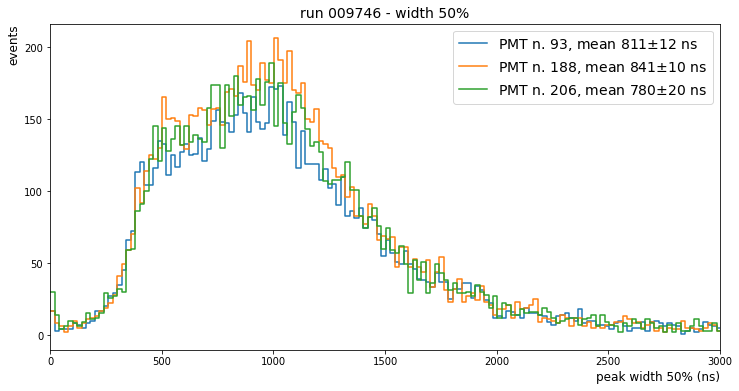

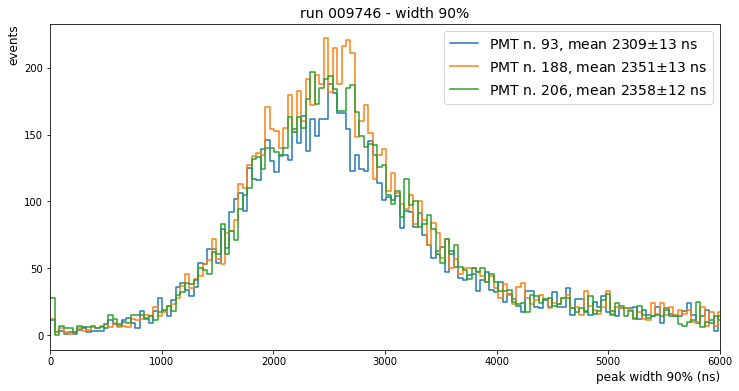

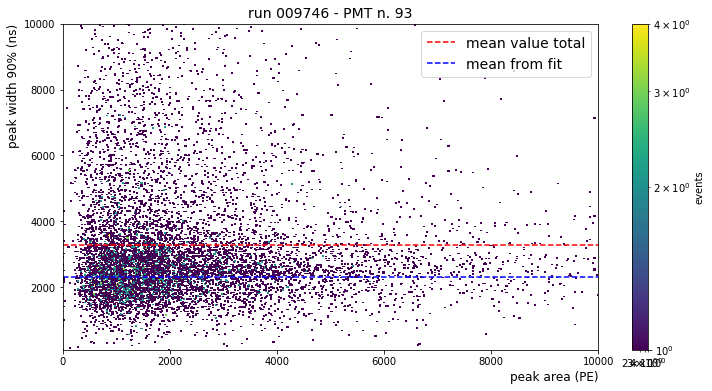

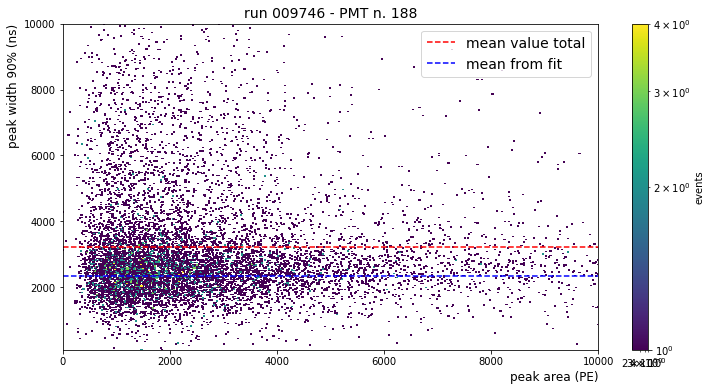

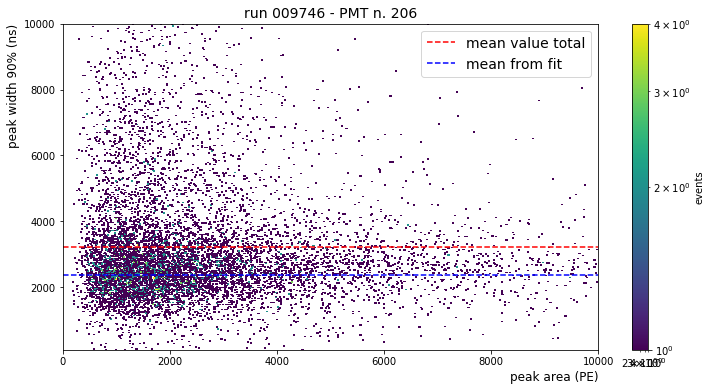

In [30]:
plot_area_width90_position(run_id, PMTs, 1e4, 10000, position = 1, distance=8, plot=0)

PMT n. 93 events 10647
PMT n. 188 events 10046
PMT n. 206 events 9371


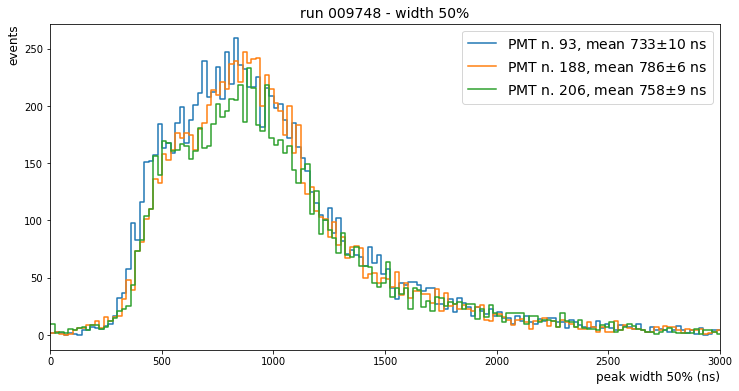

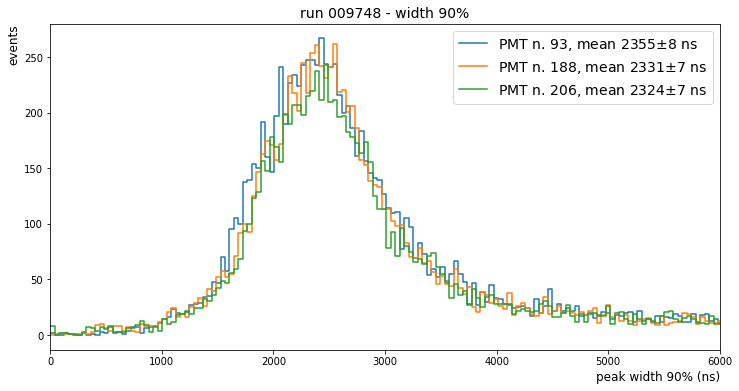

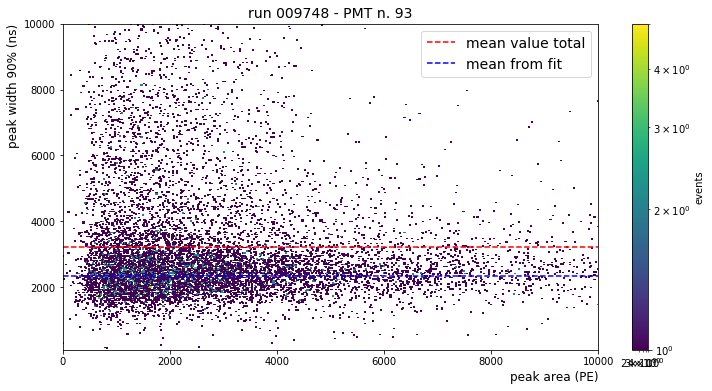

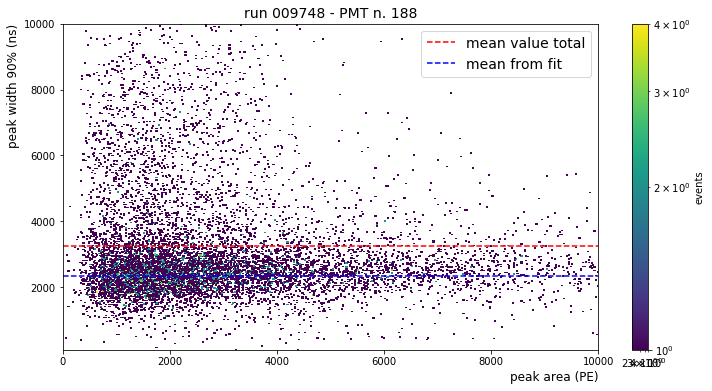

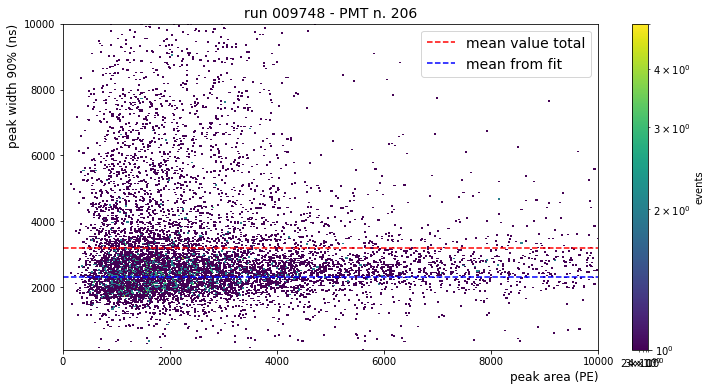

In [31]:
plot_area_width90_position(run_id2, PMTs, 1e4, 10000, position = 1, distance=8, plot=0)

In [191]:
def average_records(run_id, PMTs, position = False, distance = 8 ):
    mdata = pd.read_hdf(f'data/merged_records_run{run_id}.h5')
    mdata = mdata[(mdata['area']>500)&(mdata['drift_time']>0)&((mdata['s2_time']-mdata['s1_endtime'])>200)]
    dt = 10
    positions = straxen.pmt_positions()
    plt.figure(figsize=(12,8))
    for PMT in PMTs:
        mdata1 = mdata[mdata['channel']==PMT]
        pos_x = np.float(positions['x'][positions['i']==PMT])
        pos_y = np.float(positions['y'][positions['i']==PMT])
        if position:
            mdata1 = mdata1[(mdata1['position_x']<pos_x+distance) & (mdata1['position_x']>pos_x-distance) &
                            (mdata1['position_y']<pos_y+distance) & (mdata1['position_y']>pos_y-distance)]
        data = np.array(mdata1['data'])
        tt = np.array((mdata1['time'] - mdata1['event_time'])/dt,dtype=int)
        lens = np.array([len(i) for i in data])
        #mask = np.arange(lens.max()) < lens[:,None]
        mask = np.arange(lens.max()+tt.max())
        mask = (mask < lens[:,None]+tt[:,None]) & (mask >= tt[:,None])
        ndata = np.zeros(mask.shape, dtype=data.dtype)
        ndata[mask] = np.concatenate(data)
        avg_wf = ndata.mean(axis=0)
        print('PMT',PMT,'number of events',len(ndata),'average lenght',len(avg_wf))
        dts = np.arange(0,len(avg_wf)*dt,dt)
        plt.plot( dts, avg_wf, drawstyle='steps',label=f'Records Average for PMT {PMT}')
        plt.xlabel("time (ns)", ha='right', x=1,fontsize=12)
        plt.ylabel("ADC", ha='right', y=1,fontsize=12)
        plt.xlim(0,6000)
        plt.legend(fontsize=14)

PMT 93 number of events 44362 average lenght 8373
PMT 188 number of events 44329 average lenght 8442
PMT 206 number of events 44266 average lenght 9208


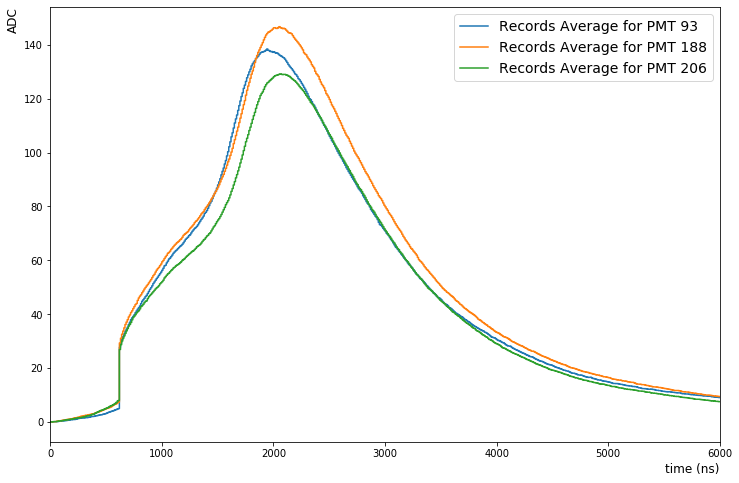

In [192]:
average_records(run_id,PMTs)

PMT 93 number of events 9092 average lenght 5926
PMT 188 number of events 10130 average lenght 8255
PMT 206 number of events 9625 average lenght 8931


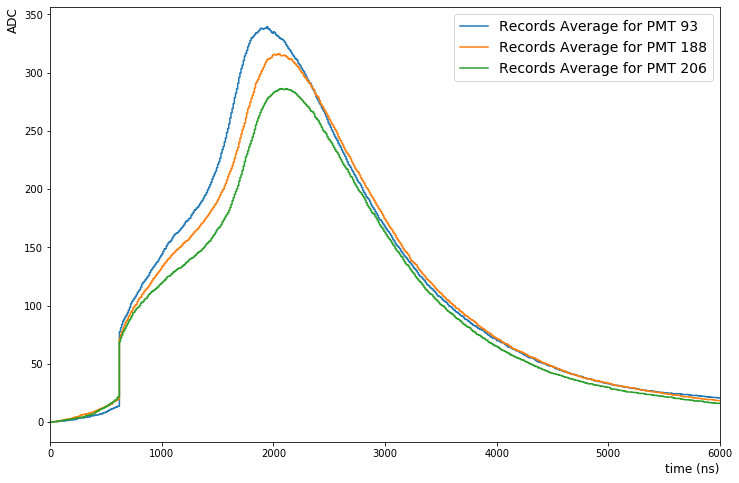

In [193]:
average_records(run_id,PMTs,1)